In [16]:
import numpy as np

def cheb(N):
    if N == 0:
        return 0, 1

    # Chebyshev nodes
    x = np.cos(np.pi * np.arange(N+1) / N)

    # Coefficients for the Chebyshev differentiation matrix
    c = np.concatenate(([2], np.ones(N-1), [2])) * (-1)**np.arange(N+1)
    #print(f"c: {c}")
    
    
    # Create the difference matrix
    X = np.tile(x, (N+1, 1)).T
    dX = X - X.T

    # Construct the Chebyshev differentiation matrix
    D = np.outer(c, 1/c) / (dX + np.eye(N+1))  # Off-diagonal entries
    D = D - np.diag(np.sum(D, axis=1))  # Diagonal entries

    return D, x


In [43]:
import numpy as np
from scipy.linalg import expm

# Parameters
N = 2**6
D, x = cheb(N)
x = x[1:N]                 # MATLAB: x = x(2:N)

# Initial condition
w = 0.53*x + 0.47*np.sin(-1.5*np.pi*x) - x
u = np.concatenate(([1], w + x, [-1]))

# Precompute ETDRK4 quantities
h = 1/4
M = 32

r = 15 * np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)

L = D @ D
L = 0.01 * L[1:N, 1:N]

A = h * L
E = expm(A)
E2 = expm(A / 2)

I = np.eye(N-1)
Z = np.zeros((N-1, N-1))

f1 = Z.copy()
f2 = Z.copy()
f3 = Z.copy()
Q  = Z.copy()

for j in range(M):
    z = r[j]
    zIA = np.linalg.inv(z * I - A)

    Q  = Q + h * zIA * (np.exp(z/2) - 1)
    f1 = f1 + h * zIA * (-4 - z + np.exp(z)*(4 - 3*z + z**2)) / z**2
    f2 = f2 + h * zIA * (2 + z + np.exp(z)*(z - 2)) / z**2
    f3 = f3 + h * zIA * (-4 - 3*z - z**2 + np.exp(z)*(4 - z)) / z**2

Q  = np.real(Q)/M
f1 = np.real(f1)/M
f2 = np.real(f2)/M
f3 = np.real(f3)/M

# Main time-stepping loop
uu = u.reshape(-1, 1)
tt = np.array([0.0])

tmax = 70
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 70) / h))

for n in range(1, nmax + 1):
    t = n * h

    Nu = (w + x) - (w + x)**3
    a  = E2 @ w + Q @ Nu
    Na = a + x - (a + x)**3

    b  = E2 @ w + Q @ Na
    Nb = b + x - (b + x)**3

    c  = E2 @ a + Q @ (2*Nb - Nu)
    Nc = c + x - (c + x)**3

    w = E @ w + f1 @ Nu + 2*f2 @ (Na + Nb) + f3 @ Nc

    if n % nplt == 0:
        u = np.concatenate(([1], w + x, [-1]))
        uu = np.hstack((uu, u.reshape(-1, 1)))
        tt = np.append(tt, t)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

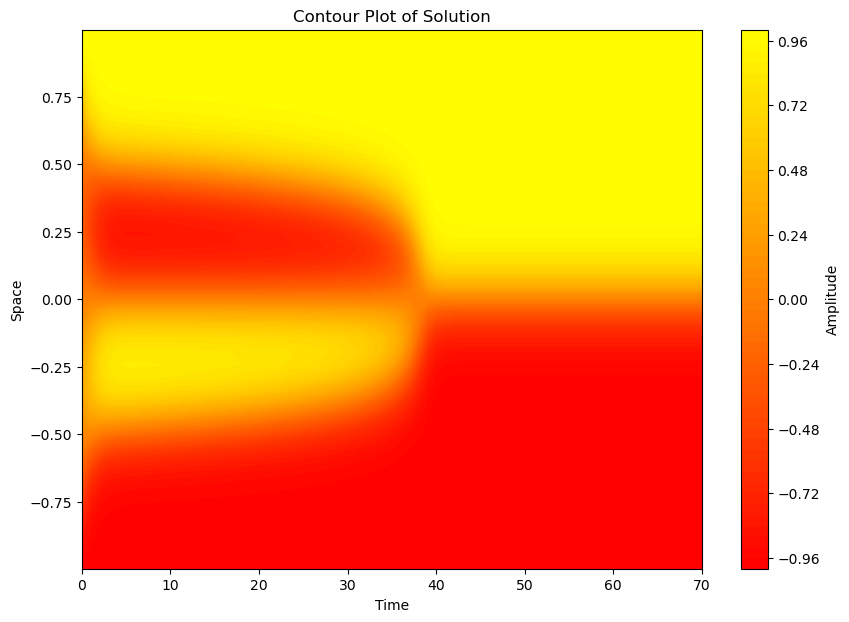

In [45]:
# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt, indexing='ij')  # Ensure consistent indexing
contour = ax.contourf(T, X, uu[1:N], levels=50, cmap=cm.autumn)  # Swap X and T to match uu's shape

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Contour Plot of Solution')

plt.show()


In [47]:
from matplotlib.animation import FuncAnimation, PillowWriter

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, uu[1:N,0], color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(uu.min(), uu.max())
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('Allen-Cahn EQ Solution Over Time')
def update(frame):
    line.set_ydata(uu[1:N,frame])
    ax.set_title(f'Allen-Cahn EQ Solution Over Time (t = {tt[frame]/20:.2f})')
    return line,
# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('AC_eq.gif', writer=PillowWriter(fps=20))

plt.close(fig)